# Compare RAPL to CodeCarbon estimation with CPU load

In [96]:
import pandas as pd

In [97]:
# !pip install matplotlib

In [98]:
def get_df(csv):
    df = pd.read_csv(csv)
    df = df.sort_values(by='cpu_load')
    return df

def display_df(df):
    return df["cores_used	cpu_load	temperature	cpu_freq	rapl_power	estimated_power	tapo_power	tapo_energy".split("\t")]

def plot(df, with_tapo=False):
    # Plot the power in Y and the CPU load in X
    if with_tapo:
        return df.plot(x='cpu_load', y=['tapo_power', 'rapl_power', 'estimated_power'], kind='line', title='CPU Load vs Power Consumption')
    else:
        return df.plot(x='cpu_load', y=['rapl_power', 'estimated_power'], kind='line', title='CPU Load vs Power Consumption')

## Dual Intel Xeon E5-2620 v3

The machine we use had 2 CPU Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz and 192 GB of RAM.

The TDP of the CPU is 85W in CodeCarbon database, that use https://www.intel.fr/content/www/fr/fr/products/sku/83352/intel-xeon-processor-e52620-v3-15m-cache-2-40-ghz/specifications.html as a source.

It means that 2 CPU at 100% load could consume 170W.

So CodeCarbon will use 170W as the maximum and estimate the power from the CPU load.

But what we see is that the power consumption reported by RAPL is much lower than 170W.

When using stress-ng to stress the CPU, we see:
    
```bash
stress-ng: info:  [8883]  pkg-0                  59.07 W
stress-ng: info:  [8883]  pkg-1                  63.03 W
```

So the maximum power consumption is around 120W. That mean the something is limiting the chip at 70% of his TDP.

I, the documentation of the CPU, we can see that there is a Turbo Boost frequency of 3.20 GHz and a base frequency of 2.40 GHz. So it is possible that the measured TDP is limited by the frequency, as in our log we see that we are at a maximum of 2.4 GHz. Maybe it is a indicator to get the real max power of the CPU ?



We see below that RAPL report from CodeCarbon give the same results as the tool Stress-ng when we use all core and stress them at a given percentage of the load.

But when using stress-ng to use only some core we sam a lower power consumption reported by RAPL. => This is not expected. I ran the experiment a second time and the results were the same. Our stress system does not seem to be able to really stress the CPU despite the reported load.

In [99]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/E5-2620/compare_cpu_load_and_RAPL-all_cores-Intel(R)_Xeon(R)_CPU_E5-2620_v3_@_2.40GHz-2025-01-14.csv'
df_all_cores = get_df(csv)
display_df(df_all_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,24,0.0,32.928571,1666.677792,0.513387,0.137097,0,0
1,24,10.0,34.000000,1395.867083,16.393232,16.703871,0,0
2,24,20.0,35.214286,1200.067875,30.981250,33.150000,0,0
3,24,30.0,36.428571,1200.092417,38.410990,49.546774,0,0
4,24,40.5,39.000000,1359.369958,45.282212,65.927097,0,0
5,24,50.2,40.071429,1675.181583,62.157340,82.307419,0,0
6,24,60.0,42.428571,2081.623833,61.948856,98.649355,0,0
7,24,69.9,47.428571,2600.282250,76.923346,114.920000,0,0
8,24,80.8,49.714286,2606.114833,111.884608,131.256452,0,0
9,24,89.7,51.642857,2566.944875,115.807523,147.631290,0,0


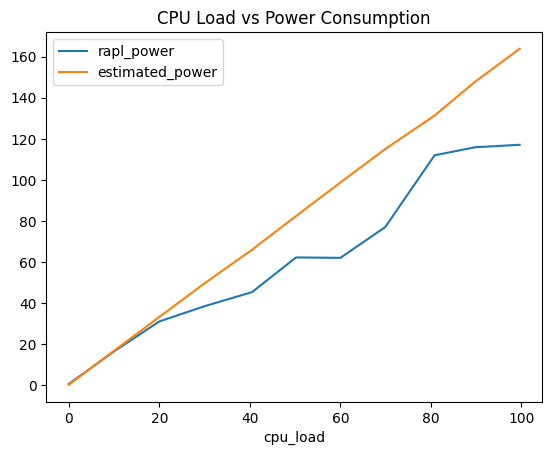

In [100]:
_ = plot(df_all_cores)

In [101]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/E5-2620/compare_cpu_load_and_RAPL-some_cores-Intel(R)_Xeon(R)_CPU_E5-2620_v3_@_2.40GHz-2025-01-14.csv'
df_some_cores = get_df(csv)
display_df(df_some_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,0,0.0,42.142857,1479.197167,0.506529,0.104194,0,0
1,2,8.7,41.000000,1316.737583,16.312251,13.852258,0,0
2,4,17.0,40.142857,1212.538958,34.766380,27.671613,0,0
3,7,29.0,41.214286,1361.311333,39.833439,48.153871,0,0
4,9,37.9,41.000000,1200.055833,49.544123,61.923871,0,0
5,12,50.0,42.214286,1254.206958,50.489318,82.455484,0,0
6,14,58.7,43.642857,1400.101208,67.126244,96.154194,0,0
7,16,66.7,44.642857,1458.430917,71.548678,109.874839,0,0
8,19,79.2,45.928571,1721.068375,72.030833,130.433871,0,0
9,21,87.5,46.214286,1712.701917,75.746365,144.105161,0,0


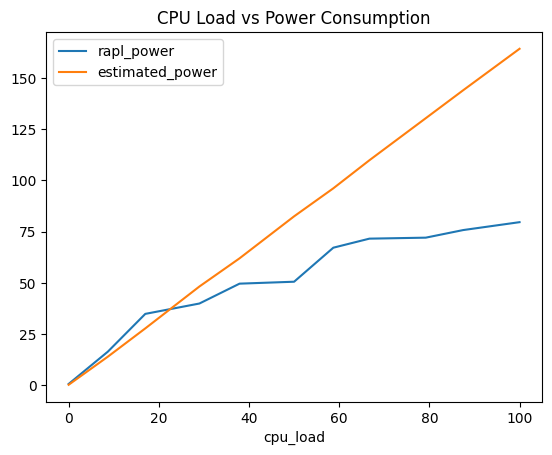

In [102]:
_ = plot(df_some_cores)

## AMD EPYC 8024P 8-Core Processor

The command `stress-ng --cpu 0 --cpu-method matrixprod --metrics-brief --rapl --perf -t 60s` give :

```bash
stress-ng: info:  [6071]  core                    1.89 W
stress-ng: info:  [6071]  pkg-0                  53.45 W
```

Here we saw that `core` is not used in the same way on AMD CPU than on Intel:

- Intel put all the core consumption in `core` and the `package` include `core`.
- AMD `core` have very low power, so we don't know if it is included in the `package` or not.

In [103]:
# !scp ubuntu@195.154.100.237:/home/ubuntu/codecarbon/*.csv ../codecarbon/data/hardware/cpu_load_profiling/AMD_EPYC_8024P_8C/

In [104]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/AMD_EPYC_8024P_8C/compare_cpu_load_and_RAPL-all_cores-AMD_EPYC_8024P_8-Core_Processor-2025-01-14.csv'
df_all_cores = get_df(csv)
display_df(df_all_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,16,0.6,0,1588.803813,0.589091,0.528387,0,0
1,16,10.0,0,1499.249313,18.614618,9.351290,0,0
2,16,20.0,0,1710.875750,29.500629,18.087097,0,0
3,16,30.0,0,2275.445813,38.665937,26.628387,0,0
4,16,40.3,0,2005.789937,41.753242,35.129032,0,0
5,16,50.0,0,2995.390687,43.218847,43.960645,0,0
6,16,64.6,0,2995.056562,47.602355,52.647097,0,0
7,16,70.2,0,2995.415937,48.713748,61.330645,0,0
8,16,80.0,0,2995.051500,49.294313,69.781935,0,0
9,16,89.4,0,2995.331437,50.717957,78.465484,0,0


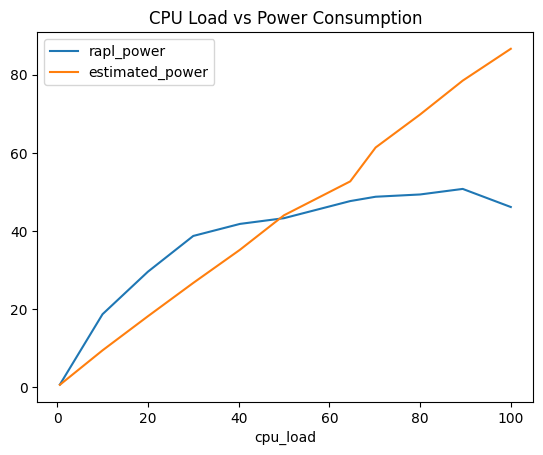

In [105]:
_ = plot(df_all_cores)

In [106]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/AMD_EPYC_8024P_8C/compare_cpu_load_and_RAPL-some_cores-AMD_EPYC_8024P_8-Core_Processor-2025-01-14.csv'
df_some_cores = get_df(csv)
display_df(df_some_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,0,0.0,0,1573.689562,0.570342,0.400645,0,0
1,1,6.8,0,1674.014938,18.321380,6.143226,0,0
2,3,18.6,0,1875.329125,37.675483,16.798065,0,0
3,4,24.8,0,1917.428375,41.647884,22.357742,0,0
4,6,37.3,0,2390.904875,43.577488,33.128710,0,0
5,8,50.3,0,2577.975125,47.224847,43.899677,0,0
6,9,56.2,0,2552.963062,49.348596,49.531935,0,0
7,11,71.6,0,2786.423500,49.929497,60.294194,0,0
8,12,78.1,0,2864.899562,51.111553,65.874194,0,0
9,14,87.5,0,2994.788312,45.597339,76.746774,0,0


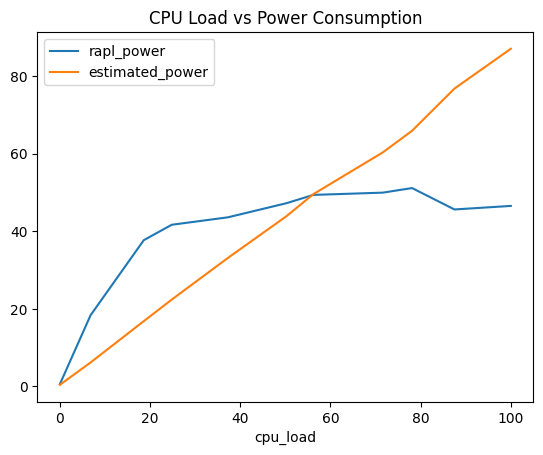

In [107]:
_ = plot(df_some_cores)

## AMD Ryzen Threadripper

In [108]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/AMD_Threadripper/compare_cpu_load_and_RAPL-all_cores-AMD_Ryzen_Threadripper_1950X_16-Core_Processor-2025-01-14.csv'
df_all_cores = get_df(csv)
display_df(df_all_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,32,2.8,34.0,2332.872375,1.376694,2.685484,115,0
1,32,13.9,39.0,2398.106938,43.301572,18.416323,147,2
2,32,23.2,49.0,2525.592844,62.548276,51.952645,198,1
3,32,36.4,46.0,2797.558437,79.171048,82.757979,226,2
4,32,44.8,51.0,2821.125656,106.327887,121.690031,257,2
5,32,53.1,52.0,2987.127656,128.126800,150.751423,219,2
6,32,66.0,56.0,3690.573406,144.148902,160.822844,285,2
7,32,72.1,57.0,3576.535531,172.434844,166.203430,278,3
8,32,83.1,56.0,3418.626969,170.324487,169.046276,279,2
9,32,91.7,56.0,3357.159875,169.175124,170.991107,277,2


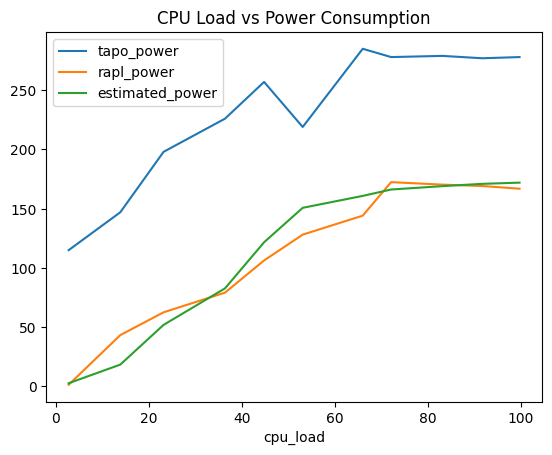

In [109]:
_ = plot(df_all_cores, with_tapo=True)

In [110]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/AMD_Threadripper/compare_cpu_load_and_RAPL-some_cores-AMD_Ryzen_Threadripper_1950X_16-Core_Processor-2025-01-14.csv'
df_some_cores = get_df(csv)
display_df(df_some_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,0,5.0,44.0,2404.504125,1.431431,2.540323,161,2
1,3,12.2,53.0,2470.488313,45.384826,15.636774,159,1
2,6,22.9,57.0,2782.765875,76.236165,45.202645,178,2
3,9,32.2,53.0,2985.716781,93.332591,79.437879,266,2
4,12,41.4,56.0,3206.834594,123.021109,106.222332,278,2
5,16,52.0,59.0,3497.221406,147.402916,151.955486,278,2
6,19,64.0,61.0,3411.514031,174.783770,161.294986,279,3
7,22,73.1,60.0,3552.373969,173.309731,165.967674,324,2
8,25,80.1,60.0,3314.471656,169.427395,169.160416,326,3
9,28,92.5,59.0,3611.685188,167.419962,170.802339,280,3


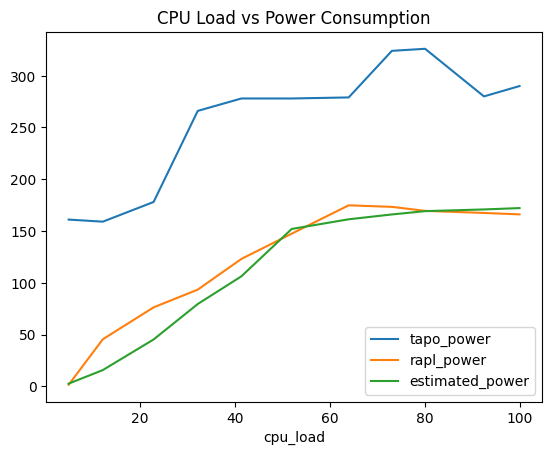

In [111]:
_ = plot(df_some_cores,with_tapo=True)

## Intel(R) Xeon(R) CPU E3-1240 V2 @ 3.40GHz

It's a 4 cores, 8 threads CPU with a TDP of 69W, according to https://www.intel.com/content/www/us/en/products/sku/65730/intel-xeon-processor-e31240-v2-8m-cache-3-40-ghz/specifications.html, and that's what we have in codeCarbon database.

`lscpu` report a max frequency of 3.8 GHz, for a base of 3.4 GHz.

On this machine, RAPL report one `core` and one `package`, but no `dram`.

When using stress-ng to stress the CPU, we see:
    
```bash
stress-ng --cpu 0 --cpu-method matrixprod --metrics-brief --rapl --perf -t 60s
...
stress-ng: info:  [6722]  core                   43.31 W
stress-ng: info:  [6722]  pkg-0                  47.26 W
...
```

So here `core` seems to be included in `package`, that were not the case for the AMD Threadripper.

So we must not update CodeCarbon to include the `core` in the energy measurement of the `package`.

In [112]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/E3-1240/compare_cpu_load_and_RAPL-all_cores-Intel(R)_Xeon(R)_CPU_E3-1240_V2_@_3.40GHz-2025-01-14.csv'
df_all_cores = get_df(csv)
display_df(df_all_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,8,2.5,49.0,1599.327875,0.176279,0.905903,0,0
1,8,12.5,49.8,1599.292875,5.508811,7.701290,0,0
2,8,21.8,49.8,1615.887000,6.874428,14.458839,0,0
3,8,32.5,51.2,1608.707625,8.150963,21.122903,0,0
4,8,41.2,52.6,1774.674000,9.590357,27.519871,0,0
5,8,51.3,67.0,3691.394500,14.386126,34.119387,0,0
6,8,60.8,67.8,3203.470375,24.131781,40.801258,0,0
7,8,71.3,82.6,3592.053000,29.980918,47.273903,0,0
8,8,80.2,86.0,3594.703500,44.586925,53.581839,0,0
9,8,88.9,84.6,3591.723000,47.199718,60.172452,0,0


<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

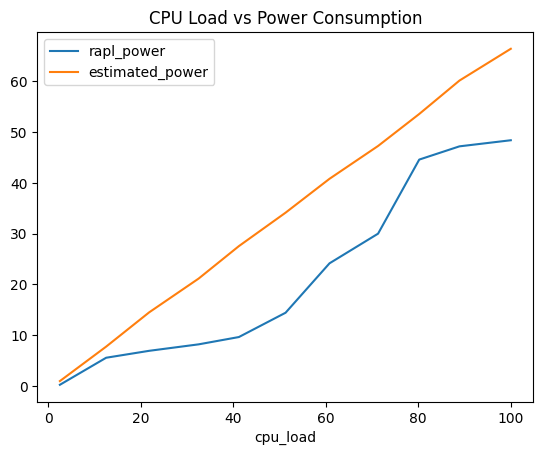

In [113]:
plot(df_all_cores)


<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

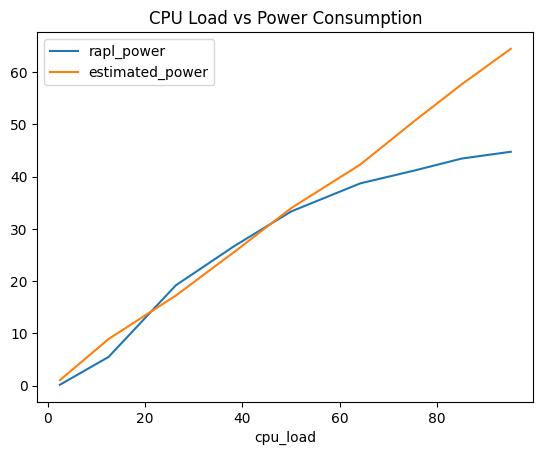

In [114]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/E3-1240/compare_cpu_load_and_RAPL-some_cores-Intel(R)_Xeon(R)_CPU_E3-1240_V2_@_3.40GHz-2025-01-11.csv'
df_some_cores = get_df(csv)
plot(df_some_cores)

## Side notes

We have to find what the real TDP of CPU is. Because for the Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz, the TDP is 85 W, but the real TDP seems to be 60 W.

```sh
$ stress-ng --cpu 0 --cpu-method matrixprod --metrics-brief --rapl --perf -t 60s
stress-ng: info:  [9573] setting to a 1 min run per stressor
stress-ng: info:  [9573] dispatching hogs: 24 cpu
stress-ng: metrc: [9573] stressor       bogo ops real time  usr time  sys time   bogo ops/s     bogo ops/s
stress-ng: metrc: [9573]                           (secs)    (secs)    (secs)   (real time) (usr+sys time)
stress-ng: metrc: [9573] cpu              614145     60.00   1439.79      0.04     10235.00         426.54
stress-ng: info:  [9573] Cannot read perf counters, do not have CAP_SYS_ADMIN capability or /proc/sys/kernel/perf_event_paranoid is set too high (4)
stress-ng: info:  [9573] cpu:
stress-ng: info:  [9573]  dram                    6.09 W
stress-ng: info:  [9573]  pkg-0                  51.78 W
stress-ng: info:  [9573]  pkg-1                  54.41 W
stress-ng: info:  [9573] skipped: 0
stress-ng: info:  [9573] passed: 24: cpu (24)
stress-ng: info:  [9573] failed: 0
stress-ng: info:  [9573] metrics untrustworthy: 0
stress-ng: info:  [9573] successful run completed in 1 min
```

```sh
ubuntu@sd-175544:~/codecarbon$ hatch run python examples/intel_rapl_show.py
Detailed RAPL Domain Information:
{
  "intel-rapl:1": {
    "name": "intel-rapl:1",
    "files": {
      "uevent": "",
      "energy_uj": "22464335801",
      "enabled": "0",
      "constraint_1_max_power_uw": "170000000",
      "constraint_1_time_window_us": "7808",
      "constraint_1_power_limit_uw": "102000000",
      "constraint_0_time_window_us": "9994240",
      "constraint_1_name": "short_term",
      "constraint_0_power_limit_uw": "85000000",
      "constraint_0_name": "long_term",
      "name": "package-1",
      "constraint_0_max_power_uw": "85000000",
      "max_energy_range_uj": "262143328850"
    },
    "subdomain_details": {}
  },
  "intel-rapl:0": {
    "name": "intel-rapl:0",
    "files": {
      "uevent": "",
      "energy_uj": "23712361659",
      "enabled": "0",
      "constraint_1_max_power_uw": "170000000",
      "constraint_1_time_window_us": "7808",
      "constraint_1_power_limit_uw": "102000000",
      "constraint_0_time_window_us": "9994240",
      "constraint_1_name": "short_term",
      "constraint_0_power_limit_uw": "85000000",
      "constraint_0_name": "long_term",
      "name": "package-0",
      "constraint_0_max_power_uw": "85000000",
      "max_energy_range_uj": "262143328850"
    },
    "subdomain_details": {}
  }
}

Potential RAM Domains:
Available Power Domains:
Starting Power Monitoring:
Power Consumption: 12.82 Watts
Power Consumption: 14.27 Watts
Power Consumption: 14.43 Watts
```

```sh
ubuntu@sd-175544:~/codecarbon$ lscpu
Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   24
  On-line CPU(s) list:    0-23
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz
    CPU family:           6
    Model:                63
    Thread(s) per core:   2
    Core(s) per socket:   6
    Socket(s):            2
    Stepping:             2
    CPU(s) scaling MHz:   41%
    CPU max MHz:          3200.0000
    CPU min MHz:          1200.0000
    BogoMIPS:             4799.72
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_
                          tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pd
                          cm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm cpuid_fault epb pti ssbd ibrs ibpb stibp tpr_shadow fle
                          xpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid cqm xsaveopt cqm_llc cqm_occup_llc dtherm ida arat pln pts vnmi md_clear flush_
                          l1d
Virtualization features:
  Virtualization:         VT-x
Caches (sum of all):
  L1d:                    384 KiB (12 instances)
  L1i:                    384 KiB (12 instances)
  L2:                     3 MiB (12 instances)
  L3:                     30 MiB (2 instances)
NUMA:
  NUMA node(s):           2
  NUMA node0 CPU(s):      0,2,4,6,8,10,12,14,16,18,20,22
  NUMA node1 CPU(s):      1,3,5,7,9,11,13,15,17,19,21,23
Vulnerabilities:
  Gather data sampling:   Not affected
  Itlb multihit:          KVM: Mitigation: VMX disabled
  L1tf:                   Mitigation; PTE Inversion; VMX conditional cache flushes, SMT vulnerable
  Mds:                    Mitigation; Clear CPU buffers; SMT vulnerable
  Meltdown:               Mitigation; PTI
  Mmio stale data:        Mitigation; Clear CPU buffers; SMT vulnerable
  Reg file data sampling: Not affected
  Retbleed:               Not affected
  Spec rstack overflow:   Not affected
  Spec store bypass:      Mitigation; Speculative Store Bypass disabled via prctl
  Spectre v1:             Mitigation; usercopy/swapgs barriers and __user pointer sanitization
  Spectre v2:             Mitigation; Retpolines; IBPB conditional; IBRS_FW; STIBP conditional; RSB filling; PBRSB-eIBRS Not affected; BHI Not affected
  Srbds:                  Not affected
  Tsx async abort:        Not affected
```

```sh
ubuntu@sd-175544:~/codecarbon$ hatch run python
Python 3.12.3 (main, Nov  6 2024, 18:32:19) [GCC 13.2.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> from cpuinfo import get_cpu_info
>>> get_cpu_info()
{'python_version': '3.12.3.final.0 (64 bit)', 'cpuinfo_version': [9, 0, 0], 'cpuinfo_version_string': '9.0.0', 'arch': 'X86_64', 'bits': 64, 'count': 24, 'arch_string_raw': 'x86_64', 'vendor_id_raw': 'GenuineIntel', 'brand_raw': 'Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz', 'hz_advertised_friendly': '2.4000 GHz', 'hz_actual_friendly': '2.3737 GHz', 'hz_advertised': [2400000000, 0], 'hz_actual': [2373723000, 0], 'stepping': 2, 'model': 63, 'family': 6, 'flags': ['abm', 'acpi', 'aes', 'aperfmperf', 'apic', 'arat', 'arch_perfmon', 'avx', 'avx2', 'bmi1', 'bmi2', 'bts', 'clflush', 'cmov', 'constant_tsc', 'cpuid', 'cpuid_fault', 'cqm', 'cqm_llc', 'cqm_occup_llc', 'cx16', 'cx8', 'dca', 'de', 'ds_cpl', 'dtes64', 'dtherm', 'dts', 'epb', 'ept', 'ept_ad', 'erms', 'est', 'f16c', 'flexpriority', 'flush_l1d', 'fma', 'fpu', 'fsgsbase', 'fxsr', 'ht', 'ibpb', 'ibrs', 'ida', 'invpcid', 'lahf_lm', 'lm', 'mca', 'mce', 'md_clear', 'mmx', 'monitor', 'movbe', 'msr', 'mtrr', 'nonstop_tsc', 'nopl', 'nx', 'osxsave', 'pae', 'pat', 'pbe', 'pcid', 'pclmulqdq', 'pdcm', 'pdpe1gb', 'pebs', 'pge', 'pln', 'pni', 'popcnt', 'pqm', 'pse', 'pse36', 'pti', 'pts', 'rdrand', 'rdrnd', 'rdtscp', 'rep_good', 'sdbg', 'sep', 'smep', 'smx', 'ss', 'ssbd', 'sse', 'sse2', 'sse4_1', 'sse4_2', 'ssse3', 'stibp', 'syscall', 'tm', 'tm2', 'tpr_shadow', 'tsc', 'tsc_adjust', 'tsc_deadline_timer', 'tscdeadline', 'vme', 'vmx', 'vnmi', 'vpid', 'x2apic', 'xsave', 'xsaveopt', 'xtopology', 'xtpr'], 'l3_cache_size': 15728640, 'l2_cache_size': 3145728, 'l1_data_cache_size': 393216, 'l1_instruction_cache_size': 393216, 'l2_cache_line_size': 256, 'l2_cache_associativity': 6}
>>>
```

Is NUMA node(s) giving the number of physical CPU?

```sh
ubuntu@sd-175544:~/codecarbon$ sudo dmidecode -t 4
# dmidecode 3.5
Getting SMBIOS data from sysfs.
SMBIOS 2.8 present.

Handle 0x0400, DMI type 4, 42 bytes
Processor Information
	Socket Designation: CPU1
	Type: Central Processor
	Family: Xeon
	Manufacturer: Intel
	ID: F2 06 03 00 FF FB EB BF
	Signature: Type 0, Family 6, Model 63, Stepping 2
	Flags:
		FPU (Floating-point unit on-chip)
		VME (Virtual mode extension)
		DE (Debugging extension)
		PSE (Page size extension)
		TSC (Time stamp counter)
		MSR (Model specific registers)
		PAE (Physical address extension)
		MCE (Machine check exception)
		CX8 (CMPXCHG8 instruction supported)
		APIC (On-chip APIC hardware supported)
		SEP (Fast system call)
		MTRR (Memory type range registers)
		PGE (Page global enable)
		MCA (Machine check architecture)
		CMOV (Conditional move instruction supported)
		PAT (Page attribute table)
		PSE-36 (36-bit page size extension)
		CLFSH (CLFLUSH instruction supported)
		DS (Debug store)
		ACPI (ACPI supported)
		MMX (MMX technology supported)
		FXSR (FXSAVE and FXSTOR instructions supported)
		SSE (Streaming SIMD extensions)
		SSE2 (Streaming SIMD extensions 2)
		SS (Self-snoop)
		HTT (Multi-threading)
		TM (Thermal monitor supported)
		PBE (Pending break enabled)
	Version: Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz
	Voltage: 1.3 V
	External Clock: 8000 MHz
	Max Speed: 4000 MHz
	Current Speed: 2400 MHz
	Status: Populated, Enabled
	Upgrade: Socket LGA2011-3
	L1 Cache Handle: 0x0700
	L2 Cache Handle: 0x0701
	L3 Cache Handle: 0x0702
	Serial Number: Not Specified
	Asset Tag: Not Specified
	Part Number: Not Specified
	Core Count: 6
	Core Enabled: 6
	Thread Count: 12
	Characteristics:
		64-bit capable
		Multi-Core
		Hardware Thread
		Execute Protection
		Enhanced Virtualization
		Power/Performance Control

Handle 0x0401, DMI type 4, 42 bytes
Processor Information
	Socket Designation: CPU2
	Type: Central Processor
	Family: Xeon
	Manufacturer: Intel
	ID: F2 06 03 00 FF FB EB BF
	Signature: Type 0, Family 6, Model 63, Stepping 2
	Flags:
		FPU (Floating-point unit on-chip)
		VME (Virtual mode extension)
		DE (Debugging extension)
		PSE (Page size extension)
		TSC (Time stamp counter)
		MSR (Model specific registers)
		PAE (Physical address extension)
		MCE (Machine check exception)
		CX8 (CMPXCHG8 instruction supported)
		APIC (On-chip APIC hardware supported)
		SEP (Fast system call)
		MTRR (Memory type range registers)
		PGE (Page global enable)
		MCA (Machine check architecture)
		CMOV (Conditional move instruction supported)
		PAT (Page attribute table)
		PSE-36 (36-bit page size extension)
		CLFSH (CLFLUSH instruction supported)
		DS (Debug store)
		ACPI (ACPI supported)
		MMX (MMX technology supported)
		FXSR (FXSAVE and FXSTOR instructions supported)
		SSE (Streaming SIMD extensions)
		SSE2 (Streaming SIMD extensions 2)
		SS (Self-snoop)
		HTT (Multi-threading)
		TM (Thermal monitor supported)
		PBE (Pending break enabled)
	Version: Intel(R) Xeon(R) CPU E5-2620 v3 @ 2.40GHz
	Voltage: 1.3 V
	External Clock: 8000 MHz
	Max Speed: 4000 MHz
	Current Speed: 2400 MHz
	Status: Populated, Enabled
	Upgrade: Socket LGA2011-3
	L1 Cache Handle: 0x0703
	L2 Cache Handle: 0x0704
	L3 Cache Handle: 0x0705
	Serial Number: Not Specified
	Asset Tag: Not Specified
	Part Number: Not Specified
	Core Count: 6
	Core Enabled: 6
	Thread Count: 12
	Characteristics:
		64-bit capable
		Multi-Core
		Hardware Thread
		Execute Protection
		Enhanced Virtualization
		Power/Performance Control
```

For the AMD EPYC 8024P 8-Core Processor, the TDP is 90 W, but the real TDP seems to be 60 W.

For Threadripper 1950X

```sh
stress-ng --cpu 0 --cpu-method matrixprod --metrics-brief --rapl --perf -t 60s
stress-ng: info:  [135178] setting to a 1 min run per stressor
stress-ng: info:  [135178] dispatching hogs: 128 cpu
stress-ng: metrc: [135178] stressor       bogo ops real time  usr time  sys time   bogo ops/s     bogo ops/s
stress-ng: metrc: [135178]                           (secs)    (secs)    (secs)   (real time) (usr+sys time)
stress-ng: metrc: [135178] cpu             1028008     60.02   1908.89      0.59     17128.73         538.37
stress-ng: info:  [135178] Cannot read perf counters, do not have CAP_SYS_ADMIN capability or /proc/sys/kernel/perf_event_paranoid is set too high (4)
stress-ng: info:  [135178] cpu:
stress-ng: info:  [135178]  core                    8.57 W
stress-ng: info:  [135178]  pkg-0-die-0           169.95 W
stress-ng: info:  [135178]  pkg-0-die-1           169.95 W
stress-ng: info:  [135178] skipped: 0
stress-ng: info:  [135178] passed: 128: cpu (128)
stress-ng: info:  [135178] failed: 0
stress-ng: info:  [135178] metrics untrustworthy: 0
stress-ng: info:  [135178] successful run completed in 1 min
```

Intel(R) Xeon(R) CPU E3-1240 V2 @ 3.40GHz

```sh
$ stress-ng --cpu 0 --cpu-method matrixprod --metrics-brief --rapl --perf -t 60s
stress-ng: info:  [5175] setting to a 1 min run per stressor
stress-ng: info:  [5175] dispatching hogs: 8 cpu
stress-ng: metrc: [5175] stressor       bogo ops real time  usr time  sys time   bogo ops/s     bogo ops/s
stress-ng: metrc: [5175]                           (secs)    (secs)    (secs)   (real time) (usr+sys time)
stress-ng: metrc: [5175] cpu              342094     60.00    475.41      0.94      5701.11         718.15
stress-ng: info:  [5175] Cannot read perf counters, do not have CAP_SYS_ADMIN capability or /proc/sys/kernel/perf_event_paranoid is set too high (4)
stress-ng: info:  [5175] cpu:
stress-ng: info:  [5175]  core                   40.44 W
stress-ng: info:  [5175]  pkg-0                  44.00 W
stress-ng: info:  [5175] skipped: 0
stress-ng: info:  [5175] passed: 8: cpu (8)
stress-ng: info:  [5175] failed: 0
stress-ng: info:  [5175] metrics untrustworthy: 0
stress-ng: info:  [5175] successful run completed in 1 min
```
